# NLP First Homework: Named Entity Recognition (NER)

First Homework for the NLP course\
Date: April 19th 2022

Sofia Torcha - 1679164

Name Entity Recognition (NER) is a sequence labelling task that aims at locating and classifying named entities mentioned in a corpus into categories.\
For this tasks the following labels are considered:\
PER (Person),\
CORP (Corporation),\
LOC (Location),\
PROD (Product),\
GRP (Group),\
CW (Creative Work),\
O (for no named entity).

For each label the BIO format is used:  a label has the prefix B- if it is the beginning of some consecutive named entities, and has the prefix I- otherwise. Therefore the labels are actually 13: B-PER, B-LOC, B-GRP, B-CORP, B-PROD, B-CW, I-PER, I-LOC, I-GRP, I-CORP, I-PROD, I-CW and O. 

In [1]:
import torch
from torch import nn
import random
import itertools
from matplotlib import pyplot as plt
import os

import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
import seaborn

import MakeDataset as md
import NERTaggerModel as pt
import Trainer as tr
import SkipGram as sk
import Word2VecDataset as wv
import SKTrainer as sktr

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [10]:
train_path = '../../data/train.tsv'
dev_path = '../../data/dev.tsv'
output_folder = '../../model/Output folder'

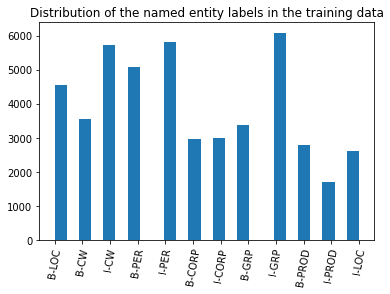

In [3]:
train_data = pd.read_csv(train_path, sep='\t', header=None)
train_data = train_data.rename(columns = {0:'token',1:'label',2:'id'})
train_data.head()

cond = train_data['label'].apply(lambda x: x != 'O' and x!='id')
plt.hist(train_data[cond]['label'],bins=25)
plt.xticks(rotation=80)
plt.title('Distribution of the named entity labels in the training data')
plt.show()

The training set is used to build a vocabulary consisting of the most 15000 frequent distinct tokens, using the string 'UNK' to encode OutOfVocabulary words, and the string 'pad' for padding (used later to build training and validation sets).\
The two dataset are also preprocessed before being used for the training: for each sentence in the dataset, a rolling window of  length  30 is used to create subsequences of the same size shifting the window of a single token each time, applying padding when needed. The sequences of tokens, together with the related label sequences, are encoded using the previous vocabulary and a label dictionary. The label dictionary also contains a label for the padding. For all the experiments, a batch size of 100 was employed.

In [4]:
stop_token = '#'
unk_token = 'UNK'
pad_token = '<pad>'

window_size = 30
window_shift = 1
vocab_size = 15000

In [5]:
data = md.MakeDataset(train_path, window_size, window_shift, stop_token, unk_token, pad_token, vocab_size)

train_dataset = data.make_dataset(train_path)
dev_dataset = data.make_dataset(dev_path)

In [6]:
print(data.label2id)

{'O': 0, 'I-GRP': 1, 'I-PER': 2, 'I-CW': 3, 'B-PER': 4, 'B-LOC': 5, 'B-CW': 6, 'B-GRP': 7, 'I-CORP': 8, 'B-CORP': 9, 'B-PROD': 10, 'I-LOC': 11, 'I-PROD': 12, '<pad>': 13}


In [7]:
train_dataset = DataLoader(train_dataset, batch_size = 100, shuffle = True)
dev_dataset = DataLoader(dev_dataset, batch_size = 100, shuffle = False)

## Simplest models: LSTM recurrent neural networks

The base model structure used for this task is the LSTM model. This is a particular model of recurrent neural network able to work with long sequences of data and to learn long dependencies among them. Starting from LSTM, the model can be extended: Bi-LSTM and Bi-LSTM CRF have also been taken into account. Here, the best hyperparameters are reported.

In [8]:
class HParams():
    vocab_size = vocab_size
    hidden_dim = 50
    embedding_dim = 200
    num_classes = 14       #includes the padding label
    bidirectional = False
    num_layers = 1
    dropout = 0.0
    embeddings = None
    crf = False
    loss_function = nn.CrossEntropyLoss(ignore_index = data.label2id[pad_token]) 
params = HParams()

In [11]:
tagger = pt.NERTaggerModel(params)
'''
trainer = tr.Trainer(
    model = tagger,
    optimizer = optim.Adam(tagger.parameters()),
    label_vocab = data.label2id,
)
'''
model_path = 'state_LSTM.pt'
#torch.save(tagger.state_dict(),os.path.join(output_folder,model_path))
tagger.load_state_dict(torch.load(os.path.join(output_folder, model_path)))

<All keys matched successfully>

## Word2Vec word-embedding
In order to increase the performances of the model, SkipGram algorithm was used to train a word embedding and avoid a random initialization of the weights. For this task Skipgram Word2Vec used a context size of length 5 to match tokens belonging to the same context.

In [12]:
w2v_window_size = 5
sk_epochs = 5

word2vec = wv.Word2VecDataset(
    data.tok_sentences, 
    data.word2id, 
    w2v_window_size, 
    data.frequency, 
    data.tot_occurrences
)
word2vec = DataLoader(word2vec,batch_size = 100)

In [13]:
embedding_dim = 200
sk_model = sk.SkipGram(vocab_size, embedding_dim, data.id2word)
sk_trainer = sktr.SKTrainer(sk_model, optim.Adam(sk_model.parameters()))
#sk_history = sk_trainer.train(word2vec, output_folder, vocab_size, sk_epochs)
weights = sk_model.state_dict()['output_weights.weight']

In [14]:
class HParams():
    vocab_size = vocab_size
    hidden_dim = 50
    embedding_dim = 200
    num_classes = 14      
    bidirectional = False
    num_layers = 1
    dropout = 0.0
    embeddings = weights   
    crf = False
    loss_function = nn.CrossEntropyLoss(ignore_index = data.label2id[pad_token]) 
params = HParams()

In [15]:
tagger = pt.NERTaggerModel(params)
'''
trainer = tr.Trainer(
    model = tagger,
    optimizer = optim.Adam(tagger.parameters()),
    label_vocab = data.label2id,
)
'''
model_path = 'state_LSTM_W2V.pt'
#torch.save(tagger.state_dict(),os.path.join(output_folder,model_path))
tagger.load_state_dict(torch.load(os.path.join(output_folder, model_path)))

<All keys matched successfully>

## Bi-LSTM and dropout layers

A Bi-LSTM neural network is a model consisting of two LSTM, one reading the input in the forward direction, the other in the opposite direction. This allows the model to consider also the "future" context of a token in order to predict its label. Such a model can be further improved by enabling a dropout layer. It was indeed shown that a dropout layer can help decreasing the risk of overfitting so a first dropout layer was inserted after the embedding layer, and a second one after the LSTM layers

## Bi-LSTM CRF models

The most complex tested model is the Bi-LSTM CRF model: a Bi-LSTM neural network followed by a conditional random field layer. The output computed by the Bi-LSTM is represented by a sequence of vectors that contains the scores assigned to the labels. These vectors become the inputs for a CRF layer that select the "best" label taking into account a transition matrix $A$ where the element $A(i,j)$ represents the score of transitioning from label $i$ to label $j$.

In [16]:
class HParams():
    vocab_size = vocab_size
    hidden_dim = 50
    embedding_dim = 200
    num_classes = 14
    bidirectional = True
    num_layers = 1
    dropout = 0.2
    embeddings = weights
    crf = True
    loss_function = nn.CrossEntropyLoss(ignore_index = data.label2id[pad_token])   # ignore_index = data.label2id[pad_token]
    
params = HParams()

In [17]:
tagger = pt.NERTaggerModel(params)
'''
trainer = tr.Trainer(
    model = tagger,
    optimizer = optim.Adam(tagger.parameters()),
    label_vocab = data.label2id,
)
'''
model_path = 'state_BiLSTM_CRF_W2V.pt'
#torch.save(tagger.state_dict(),os.path.join(output_folder,model_path))
tagger.load_state_dict(torch.load(os.path.join(output_folder, model_path)))

<All keys matched successfully>

## Confusion Matrix

Confusion matrix for the last model

In [20]:
trainer = tr.Trainer(
    model = tagger,
    optimizer = optim.Adam(tagger.parameters()),
    label_vocab = data.label2id,
)
m = trainer.confusion_matrix(dev_dataset)

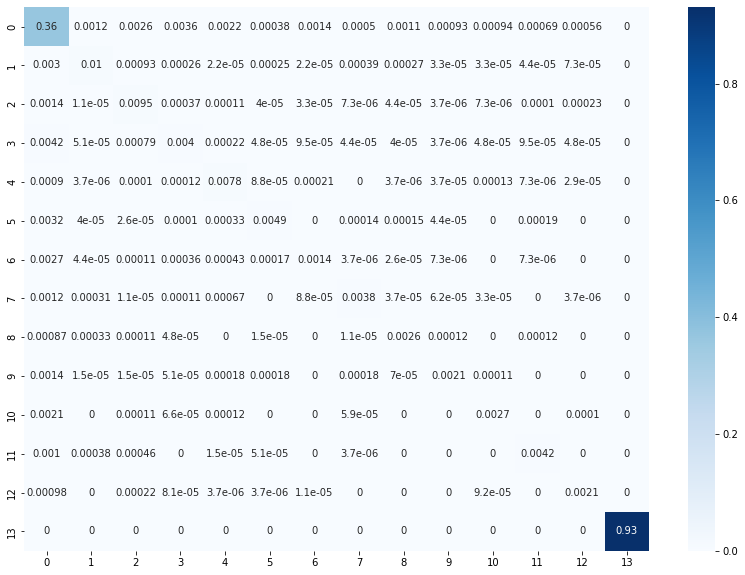

In [21]:
m = m / (np.linalg.norm(m))
plt.figure(figsize = (14,10))
s = seaborn.heatmap(m, annot = True, cmap = 'Blues')
plt.show()

# Hyperparameter tuning for Word2vec

Code used for hyperparameter tuning.\
Each model is saved in the Output folder and then evaluated.

In [153]:
train_path = '../../data/train.tsv'
dev_path = '../../data/dev.tsv'
output_folder = '../../model/Output folder'

stop_token = '#'
unk_token = 'UNK'
pad_token = '<pad>'

num_classes = 14
vocab_size = 15000

In [154]:
sk_epochs_list = [5,10,20]
window_size_list = [5, 15, 30, 40]
window_shift_list = [1]
embedding_dim_list = [50, 100, 200]
w2v_window_size_list = [5,10]
hyperparameters = [window_size_list ,window_shift_list ,embedding_dim_list, sk_epochs_list, w2v_window_size_list]
combinations = itertools.product(*hyperparameters)

In [156]:
for hyp in iter(combinations):
    window_size = hyp[0]
    window_shift = hyp[1]
    embedding_dim = hyp[2]
    sk_epochs = hyp[3]
    w2v_window_size = hyp[4]

    data = md.MakeDataset(train_path, window_size, window_shift, stop_token, unk_token, pad_token, vocab_size)
    train_dataset = data.make_dataset(train_path)
    train_dataset = DataLoader(train_dataset, batch_size = 100, shuffle = True)
    dev_dataset = data.make_dataset(dev_path)
    dev_dataset = DataLoader(dev_dataset, batch_size = 100, shuffle = False)
    
    word2vec = wv.Word2VecDataset(
        data.tok_sentences, 
        data.word2id, 
        w2v_window_size, 
        data.frequency, 
        data.tot_occurrences
    )
    
    word2vec = DataLoader(word2vec,batch_size = 100)
    
    sk_model = sk.SkipGram(vocab_size, embedding_dim, data.id2word)
    sk_trainer = sktr.SKTrainer(sk_model, optim.Adam(sk_model.parameters()))
    sk_history = sk_trainer.train(word2vec, output_folder, vocab_size, sk_epochs)
    
    #torch.save(sk_model.state_dict(),os.path.join(output_folder, f'word_embedding_{window_size}_{window_shift}_{embedding_dim}_{sk_epochs}_{w2v_window_size}.pt')) 

# Hyperparameter tuning for the NER-tagger

In [36]:
train_path = '../../data/train.tsv'
dev_path = '../../data/dev.tsv'
output_folder = '../../model/Output folder'

stop_token = '#'
unk_token = 'UNK'
pad_token = '<pad>'

num_classes = 14
vocab_size = 15000

In [42]:
tagger_epochs_list = [4,7,10]
sk_epochs_list = [5,10,20]
w2v_window_size_list = [5,10]
dropout_list = [0.0,0.2,0.4]
window_size_list = [5, 15, 30, 40]
window_shift_list = [1]
embedding_dim_list = [50, 100, 200]
crf_list = [False, True]
bidirectional_list = [False, True] 
i = 0

hyperparameters = [window_size_list ,window_shift_list ,embedding_dim_list, dropout_list
                   sk_epochs_list, tagger_epochs_list, crf_list, bidirectional_list, w2v_window_size_list]
combinations = itertools.product(*hyperparameters)

In [43]:
for hyp in iter(combinations):
    window_size = hyp[0]
    window_shift = hyp[1]
    embedding_dim = hyp[2]
    dropout = hyp[3]
    sk_epochs = hyp[4]
    tagger_epochs = hyp[5]
    crf = hyp[6]
    bidirectional = hyp[7]
    w2v_window_size = hyp[8]
    i = i + 1
        
    data = md.MakeDataset(train_path, window_size, window_shift, stop_token, unk_token, pad_token, vocab_size)
    train_dataset = data.make_dataset(train_path)
    train_dataset = DataLoader(train_dataset, batch_size = 100, shuffle = True)
    dev_dataset = data.make_dataset(dev_path)
    dev_dataset = DataLoader(dev_dataset, batch_size = 100, shuffle = False)
    
    sk_model = sk.SkipGram(vocab_size, embedding_dim, data.id2word)
    sk_model.load_state_dict(torch.load(os.path.join(output_folder, 
                    f'word_embedding_{window_size}_{window_shift}_{embedding_dim}_{sk_epochs}_{w2v_window_size}.pt')))
    weights = sk_model.state_dict()['output_weights.weight']
    
    if merge_word_embedding:
        v_data = vwe.VectorWordEmbedding(data, num_classes)
        vectorized_data = v_data.vectorized_data
        new_weights = v_data.merge_word_embeddings(weights)
    
    class HParams():
        vocab_size = vocab_size
        hidden_dim = 20
        embedding_dim = embedding_dim
        num_classes = num_classes
        bidirectional = bidirectional
        num_layers = 1
        dropout = dropout
        embeddings = weights
        loss_function = nn.CrossEntropyLoss(ignore_index = data.label2id[pad_token])
        crf = crf
    params = HParams()

    tagger = pt.NERTaggerModel(params)    
    trainer = tr.Trainer(
        model = tagger,
        optimizer = optim.Adam(tagger.parameters()),
        label_vocab = data.label2id,
    ) 
    history = trainer.train(
        train_dataset,
        dev_dataset,
        output_folder,
        tagger_epochs,
    )
    #torch.save(tagger.state_dict(),os.path.join(output_folder, f'state_{i}.pt'))